<a href="https://colab.research.google.com/github/samehra/Projects/blob/master/tf_notebooks/preprocessing_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.


In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classify structured data using Keras preprocessing layers

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/preprocessing_layers.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/preprocessing_layers.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/structured_data/preprocessing_layers.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to classify structured data, such as tabular data, using a simplified version of the <a href="https://www.kaggle.com/c/petfinder-adoption-prediction" class="external">PetFinder dataset from a Kaggle competition</a> stored in a CSV file.

You will use [Keras](https://www.tensorflow.org/guide/keras) to define the model, and [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) as a bridge to map from columns in a CSV file to features used to train the model. The goal is to predict if a pet will be adopted.

This tutorial contains complete code for:

* Loading a CSV file into a <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html" class="external">DataFrame</a> using <a href="https://pandas.pydata.org/" class="external">pandas</a>.
* Building an input pipeline to batch and shuffle the rows using `tf.data`. (Visit [tf.data: Build TensorFlow input pipelines](../../guide/data.ipynb) for more details.)
* Mapping from columns in the CSV file to features used to train the model with the Keras preprocessing layers.
* Building, training, and evaluating a model using the Keras built-in methods.

Note: This tutorial is similar to [Classify structured data with feature columns](../structured_data/feature_columns.ipynb). This version uses the [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) instead of the `tf.feature_column` API, as the former are more intuitive and can be easily included inside your model to simplify deployment.

## The PetFinder.my mini dataset

There are several thousand rows in the PetFinder.my mini's CSV dataset file, where each row describes a pet (a dog or a cat) and each column describes an attribute, such as age, breed, color, and so on.

In the dataset's summary below, notice there are mostly numerical and categorical columns. In this tutorial, you will only be dealing with those two feature types, dropping `Description` (a free text feature) and `AdoptionSpeed` (a classification feature) during data preprocessing.

| Column          | Pet description               | Feature type   | Data type |
| --------------- | ----------------------------- | -------------- | --------- |
| `Type`          | Type of animal (`Dog`, `Cat`) | Categorical    | String    |
| `Age`           | Age                           | Numerical      | Integer   |
| `Breed1`        | Primary breed                 | Categorical    | String    |
| `Color1`        | Color 1                       | Categorical    | String    |
| `Color2`        | Color 2                       | Categorical    | String    |
| `MaturitySize`  | Size at maturity              | Categorical    | String    |
| `FurLength`     | Fur length                    | Categorical    | String    |
| `Vaccinated`    | Pet has been vaccinated       | Categorical    | String    |
| `Sterilized`    | Pet has been sterilized       | Categorical    | String    |
| `Health`        | Health condition              | Categorical    | String    |
| `Fee`           | Adoption fee                  | Numerical      | Integer   |
| `Description`   | Profile write-up              | Text           | String    |
| `PhotoAmt`      | Total uploaded photos         | Numerical      | Integer   |
| `AdoptionSpeed` | Categorical speed of adoption | Classification | Integer   |

## Import TensorFlow and other libraries


In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    cohen_kappa_score,
    confusion_matrix,
    recall_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    precision_score, f1_score
)

In [2]:
tf.__version__

'2.12.0'

## Load the dataset and read it into a pandas DataFrame

<a href="https://pandas.pydata.org/" class="external">pandas</a> is a Python library with many helpful utilities for loading and working with structured data. Use `tf.keras.utils.get_file` to download and extract the CSV file with the PetFinder.my mini dataset, and load it into a <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html" class="external">DataFrame</a> with <a href="https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html" class="external">`pandas.read_csv`</a>:

In [3]:
dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

1668792/1668792 [==============================] - 0s 0us/step


Inspect the dataset by checking the first five rows of the DataFrame:

In [4]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


## Create a target variable

The original task in Kaggle's <a href="https://www.kaggle.com/c/petfinder-adoption-prediction" class="external">PetFinder.my Adoption Prediction competition</a> was to predict the speed at which a pet will be adopted (e.g. in the first week, the first month, the first three months, and so on).

In this tutorial, you will simplify the task by transforming it into a binary classification problem, where you simply have to predict whether a pet was adopted or not.

After modifying the `AdoptionSpeed` column, `0` will indicate the pet was not adopted, and `1` will indicate it was.

In [5]:
# In the original dataset, `'AdoptionSpeed'` of `4` indicates
# a pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
dataframe = dataframe.drop(columns=['AdoptionSpeed','Description'])

In [11]:
dataframe['Health'].value_counts()

Healthy           11098
Minor Injury        409
Serious Injury       30
Name: Health, dtype: int64

In [9]:
dataframe['target'].value_counts()/len(dataframe)

1    0.733033
0    0.266967
Name: target, dtype: float64

## Split the DataFrame into training, validation, and test sets

The dataset is in a single pandas DataFrame. Split it into training, validation, and test sets using a, for example, 80:10:10 ratio, respectively:

In [6]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [7]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

9229 training examples
1154 validation examples
1154 test examples


## Create an input pipeline using tf.data

Next, create a utility function that converts each training, validation, and test set DataFrame into a `tf.data.Dataset`, then shuffles and batches the data.

Note: If you were working with a very large CSV file (so large that it does not fit into memory), you would use the `tf.data` API to read it from disk directly. That is not covered in this tutorial.

In [12]:
train.to_csv('/content/datasets/petfinder-mini/train.csv',index=False)
val.to_csv('/content/datasets/petfinder-mini/val.csv',index=False)
test.to_csv('/content/datasets/petfinder-mini/test.csv',index=False)
TRAIN_DATA_FILE = '/content/datasets/petfinder-mini/train.csv'
VAL_DATA_FILE = '/content/datasets/petfinder-mini/val.csv'
TEST_DATA_FILE = '/content/datasets/petfinder-mini/test.csv'

In [13]:
def get_col_dtypes(df):
  df_col_type = []
  SELECTED_COLUMNS = df.columns.to_list()
  for v in df[SELECTED_COLUMNS].dtypes.values:
      if v in ["object"]:
          df_col_type.append(tf.string)
      elif v in ["int64"]:
          df_col_type.append(tf.int64)
      elif v in ["float64"]:
          df_col_type.append(tf.float32)
      else:
          df_col_type.append("error")
  return SELECTED_COLUMNS, df_col_type

In [14]:
def df_to_dataset(csv_file_path, SELECTED_COLUMNS, df_col_type, batch_size=None, training=False):
  dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        # column_names=CSV_HEADER,
        # column_defaults=COLUMN_DEFAULTS,
        label_name='target',
        field_delim=",",
        num_epochs=1,
        header=True,
        shuffle=training,
        shuffle_seed=2022,
        column_defaults=df_col_type,
        select_columns=SELECTED_COLUMNS,
    )
  return dataset.prefetch(tf.data.experimental.AUTOTUNE).cache().shuffle(10000)

In [ ]:
BATCH_SIZE = 5
SELECTED_COLUMNS, df_col_type = get_col_dtypes(train)
train_ds = df_to_dataset(TRAIN_DATA_FILE, SELECTED_COLUMNS, df_col_type, batch_size=BATCH_SIZE)

In [ ]:
iterator = train_ds.as_numpy_iterator()
print(next(iterator))

(OrderedDict([('Type', array([b'Dog', b'Dog', b'Dog', b'Dog', b'Dog'], dtype=object)), ('Age', array([1, 8, 2, 2, 3])), ('Breed1', array([b'Mixed Breed', b'Mixed Breed', b'Mixed Breed', b'Mixed Breed',
       b'Mixed Breed'], dtype=object)), ('Gender', array([b'Female', b'Female', b'Female', b'Male', b'Female'], dtype=object)), ('Color1', array([b'Cream', b'Gray', b'Golden', b'Black', b'Brown'], dtype=object)), ('Color2', array([b'No Color', b'White', b'No Color', b'Brown', b'No Color'],
      dtype=object)), ('MaturitySize', array([b'Medium', b'Small', b'Medium', b'Medium', b'Medium'], dtype=object)), ('FurLength', array([b'Short', b'Short', b'Medium', b'Short', b'Short'], dtype=object)), ('Vaccinated', array([b'Yes', b'Yes', b'No', b'No', b'No'], dtype=object)), ('Sterilized', array([b'No', b'Yes', b'No', b'No', b'No'], dtype=object)), ('Health', array([b'Healthy', b'Healthy', b'Healthy', b'Healthy', b'Healthy'],
      dtype=object)), ('Fee', array([0, 0, 0, 0, 0])), ('PhotoAmt', arr

In [ ]:
# def df_to_dataset(dataframe, shuffle=True, batch_size=32):
#   df = dataframe.copy()
#   labels = df.pop('target')
#   #df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
#   ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
#   if shuffle:
#     ds = ds.shuffle(buffer_size=len(dataframe))
#   ds = ds.batch(batch_size)
#   #ds = ds.prefetch(batch_size)
#   return ds

Now, use the newly created function (`df_to_dataset`) to check the format of the data the input pipeline helper function returns by calling it on the training data, and use a small batch size to keep the output readable:

In [ ]:
# batch_size = 5
# train_ds = df_to_dataset(train, batch_size=batch_size)

<ipython-input-52-47dd34a56d8b>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [ ]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([ 4  4  6  4 84], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([1 1 0 0 1], shape=(5,), dtype=int64)


As the output demonstrates, the training set returns a dictionary of column names (from the DataFrame) that map to column values from rows.

## Apply the Keras preprocessing layers

The Keras preprocessing layers allow you to build Keras-native input processing pipelines, which can be used as independent preprocessing code in non-Keras workflows, combined directly with Keras models, and exported as part of a Keras SavedModel.

In this tutorial, you will use the following four preprocessing layers to demonstrate how to perform preprocessing, structured data encoding, and feature engineering:

- `tf.keras.layers.Normalization`: Performs feature-wise normalization of input features.
- `tf.keras.layers.CategoryEncoding`: Turns integer categorical features into one-hot, multi-hot, or <a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf" class="external">tf-idf</a>
dense representations.
- `tf.keras.layers.StringLookup`: Turns string categorical values into integer indices.
- `tf.keras.layers.IntegerLookup`: Turns integer categorical values into integer indices.

You can learn more about the available layers in the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide.

- For _numerical features_ of the PetFinder.my mini dataset, you will use a `tf.keras.layers.Normalization` layer to standardize the distribution of the data.
- For _categorical features_, such as pet `Type`s (`Dog` and `Cat` strings), you will transform them to multi-hot encoded tensors with `tf.keras.layers.CategoryEncoding`.

### Numerical columns

For each numeric feature in the PetFinder.my mini dataset, you will use a `tf.keras.layers.Normalization` layer to standardize the distribution of the data.

Define a new utility function that returns a layer which applies feature-wise normalization to numerical features using that Keras preprocessing layer:

In [15]:
def calculate_num_vocab(dataset, num_cols):
  num_vocab = {}
  mean_num, var_num = dataset[num_cols].mean().values, dataset[num_cols].var().values
  num_vocab['mean'] =  mean_num
  num_vocab['var'] =  var_num
  return num_vocab

def get_normalization_layer1(num_cols, num_vocab, dataset):
  inputs = []
  for col in num_cols:
    inputs.append(tf.keras.Input(shape=(1,), name=col, dtype=tf.float32))

  normalizer = tf.keras.layers.Normalization(axis=-1, mean=num_vocab['mean'], variance=num_vocab['var'])

  return tf.concat(inputs, axis=-1), normalizer

def get_normalization_layer2(num_vocab):
  normalizer = tf.keras.layers.Normalization(axis=-1, mean=num_vocab['mean'], variance=num_vocab['var'])

  return normalizer

In [16]:
def get_normalization_layer(name, dataset):

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)
  #normalizer.adapt(dict(dataset[numeric_features]))
  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [17]:
num_cols = ['PhotoAmt','Age']
num_vocab = calculate_num_vocab(train, num_cols)
photo_count_col = train[num_cols]
layer = get_normalization_layer2(num_vocab)
print(layer.get_weights())
layer(photo_count_col)

[]


<tf.Tensor: shape=(9229, 2), dtype=float32, numpy=
array([[-0.83088803, -0.4515712 ],
       [ 0.43429354, -0.50400114],
       [ 0.43429354, -0.50400114],
       ...,
       [-0.19829726,  5.6827307 ],
       [-0.19829726, -0.4515712 ],
       [ 0.11799814, -0.50400114]], dtype=float32)>

## Concatenate all the numeric features before passing to the normalization layer

Note: If you have many numeric features (hundreds, or more), it is more efficient to concatenate them first and use a single `tf.keras.layers.Normalization` layer.

### Categorical columns

Pet `Type`s in the dataset are represented as strings—`Dog`s and `Cat`s—which need to be multi-hot encoded before being fed into the model. The `Age` feature

Define another new utility function that returns a layer which maps values from a vocabulary to integer indices and multi-hot encodes the features using the `tf.keras.layers.StringLookup`, `tf.keras.layers.IntegerLookup`, and `tf.keras.CategoryEncoding` preprocessing layers:

In [18]:
def get_category_encoding_layer(name, dataset, dtype, vocab, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens, vocabulary=vocab[name])
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens, vocabulary=vocab[name])

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  #index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

Test the `get_category_encoding_layer` function by calling it on pet `'Type'` features to turn them into multi-hot encoded tensors:

In [ ]:
test_type_col = train['Type']
test_type_layer = get_category_encoding_layer(name='Type',
                                              dataset=train_ds,
                                              vocab=categ_dict,
                                              dtype='string')
test_type_layer(test_type_col)

<function get_category_encoding_layer.<locals>.<lambda> at 0x7f5f875e57e0>


<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 1., 1.], dtype=float32)>

Repeat the process on the pet `'Age'` features:

In [ ]:
test_age_col = train['Color1']
test_age_layer = get_category_encoding_layer(name='Color1',
                                             dataset=train_ds,
                                             dtype='string',
                                             vocab=categ_dict,
                                             max_tokens=5)
test_age_layer(test_age_col)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 1., 1., 1.], dtype=float32)>

## Preprocess selected features to train the model on

You have learned how to use several types of Keras preprocessing layers. Next, you will:

- Apply the preprocessing utility functions defined earlier on 13 numerical and categorical features from the PetFinder.my mini dataset.
- Add all the feature inputs to a list.

As mentioned in the beginning, to train the model, you will use the PetFinder.my mini dataset's numerical (`'PhotoAmt'`, `'Fee'`) and categorical (`'Age'`, `'Type'`, `'Color1'`, `'Color2'`, `'Gender'`, `'MaturitySize'`, `'FurLength'`, `'Vaccinated'`, `'Sterilized'`, `'Health'`, `'Breed1'`) features.

Note: If your aim is to build an accurate model, try a larger dataset of your own, and think carefully about which features are the most meaningful to include, and how they should be represented.

Earlier, you used a small batch size to demonstrate the input pipeline. Let's now create a new input pipeline with a larger batch size of 256:

In [19]:
BATCH_SIZE = 256
SELECTED_COLUMNS, df_col_type = get_col_dtypes(train)
train_ds = df_to_dataset(TRAIN_DATA_FILE, SELECTED_COLUMNS, df_col_type, batch_size=BATCH_SIZE)
val_ds = df_to_dataset(VAL_DATA_FILE, SELECTED_COLUMNS, df_col_type, batch_size=len(val))
test_ds = df_to_dataset(TEST_DATA_FILE, SELECTED_COLUMNS, df_col_type, batch_size=len(test))

In [ ]:
# batch_size = 256
# train_ds = df_to_dataset(train, batch_size=batch_size)
# val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
# test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

Normalize the numerical features (the number of pet photos and the adoption fee), and add them to one list of inputs called `encoded_features`:

In [20]:
class preprocessingData():

  def __init__(self, num_cols, categorical_cols, num_vocab, categ_vocab):
    self.num_cols = num_cols
    self.categorical_cols = categorical_cols
    self.num_vocab = num_vocab
    self.categ_vocab = categ_vocab
    self.all_inputs = []
    self.encoded_features = []

  def data_preprocess(self, ds):
    # Numerical features

    # for header in self.num_cols:
    #   numeric_col = tf.keras.Input(shape=(1,), name=header)
    #   normalization_layer = get_normalization_layer(header, ds)
    #   encoded_numeric_col = normalization_layer(numeric_col)
    #   self.all_inputs.append(numeric_col)
    #   self.encoded_features.append(encoded_numeric_col)
    numeric_inputs = []
    for header in self.num_cols:
      numeric_col = tf.keras.Input(shape=(1,), name=header, dtype=tf.float32)
      numeric_inputs.append(numeric_col)

    #numeric_inputs, normalization_layer = get_normalization_layer1(self.num_cols, num_vocab=self.num_vocab, dataset=ds)
    normalization_layer = get_normalization_layer2(self.num_vocab)
    concat_numeric_inputs = tf.keras.layers.Concatenate()(numeric_inputs)
    encoded_numeric_col = normalization_layer(concat_numeric_inputs)
    self.all_inputs.extend(numeric_inputs)
    self.encoded_features.append(encoded_numeric_col)

    # Categorical features
    for header in self.categorical_cols:
      categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
      encoding_layer = get_category_encoding_layer(name=header,
                                                  dataset=ds,
                                                  dtype='string',
                                                  #max_tokens=5,
                                                  vocab=self.categ_vocab,
                                                  )
      encoded_categorical_col = encoding_layer(categorical_col)
      self.all_inputs.append(categorical_col)
      self.encoded_features.append(encoded_categorical_col)

    self.concat_features = tf.keras.layers.Concatenate()(self.encoded_features)
    return self.all_inputs, self.encoded_features, self.concat_features

Turn the integer categorical values from the dataset (the pet age) into integer indices, perform multi-hot encoding, and add the resulting feature inputs to `encoded_features`:

Repeat the same step for the string categorical values:

In [21]:
from collections import Counter

num_cols = ['PhotoAmt','Fee','Age']
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

categ_cols = list(set(train.columns) - set(num_cols) - set(['target']))
categ_dict = {col: list(np.array(Counter(train[col]).most_common(3))[:,0]) for col in categ_cols}

num_vocab = calculate_num_vocab(train, num_cols)
preprocess = preprocessingData(num_cols, categorical_cols, num_vocab, categ_dict)
all_inputs, encoded_features, concat_features = preprocess.data_preprocess(train_ds)

In [22]:
concat_features

<KerasTensor: shape=(None, 41) dtype=float32 (created by layer 'concatenate_1')>

In [23]:
all_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'PhotoAmt')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Fee')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Age')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Type')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Color1')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Color2')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Gender')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'MaturitySize')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'FurLength')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Vaccinated')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Sterilized')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Health')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Breed1')>]

In [ ]:
encoded_features

[<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'normalization_4')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_30')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_31')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_32')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_33')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_34')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_35')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_36')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_37')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_38')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_39')>]

## Create, compile, and train the model


The next step is to create a model using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). For the first layer in your model, merge the list of feature inputs—`encoded_features`—into one vector via concatenation with `tf.keras.layers.concatenate`.

In [ ]:
concat_features

[<KerasTensor: shape=(None, 41) dtype=float32 (created by layer 'concatenate_17')>]

In [ ]:
[layer for layer in encoded_features if layer.name.startswith('normalization')][0]

<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'normalization_3')>

In [ ]:
[layer for layer in encoded_features if layer.name.startswith('category_encoding')]

[<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_20')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_21')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_22')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_23')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_24')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_25')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_26')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_27')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_28')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_29')>]

In [ ]:
t = tf.keras.layers.Concatenate()([layer for layer in encoded_features if layer.name.startswith('category_encoding')])
t

<KerasTensor: shape=(None, 38) dtype=float32 (created by layer 'concatenate_13')>

In [24]:
class tfModel():

  def __init__(self):
    self.dense_layer1 = tf.keras.layers.Dense(32, activation="relu")
    self.dense_layer2 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    self.dropout_layer = tf.keras.layers.Dropout(0.5)

  def model(self, all_features):
    self.all_features = all_features
    x1 = tf.keras.layers.Dense(32, activation="relu")(self.all_features)
    x1 = tf.keras.layers.Dropout(0.5)(x1)
    output1 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x1)

    # self.numeric_layers = [layer for layer in self.all_features if layer.name.startswith('normalization')][0]
    # self.categ_layers = [layer for layer in self.all_features if layer.name.startswith('category_encoding')]

    # self.concat_categ_layers = tf.keras.layers.Concatenate()(self.categ_layers)

    # x1 = tf.keras.layers.Dense(32, activation="relu")(self.concat_categ_layers)
    # x1 = tf.keras.layers.Dropout(0.5)(x1)
    # output1 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x1)

    # x2 = tf.keras.layers.Dense(32, activation="relu")(self.numeric_layers)
    # x2 = tf.keras.layers.Dropout(0.5)(x2)
    # output2 = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x2)

    # mean_nn_only = tf.reduce_mean(tf.stack([output1, output2], axis=0), axis=0)

    self.nn_only_model = tf.keras.models.Model(self.all_features, output1)
    return self.nn_only_model

Configure the model with Keras `Model.compile`:

In [27]:
preprocessing_model = tf.keras.Model(all_inputs, concat_features)
tf_model = tfModel()
training_model = tf_model.model(preprocessing_model.output)

Let's visualize the connectivity graph:


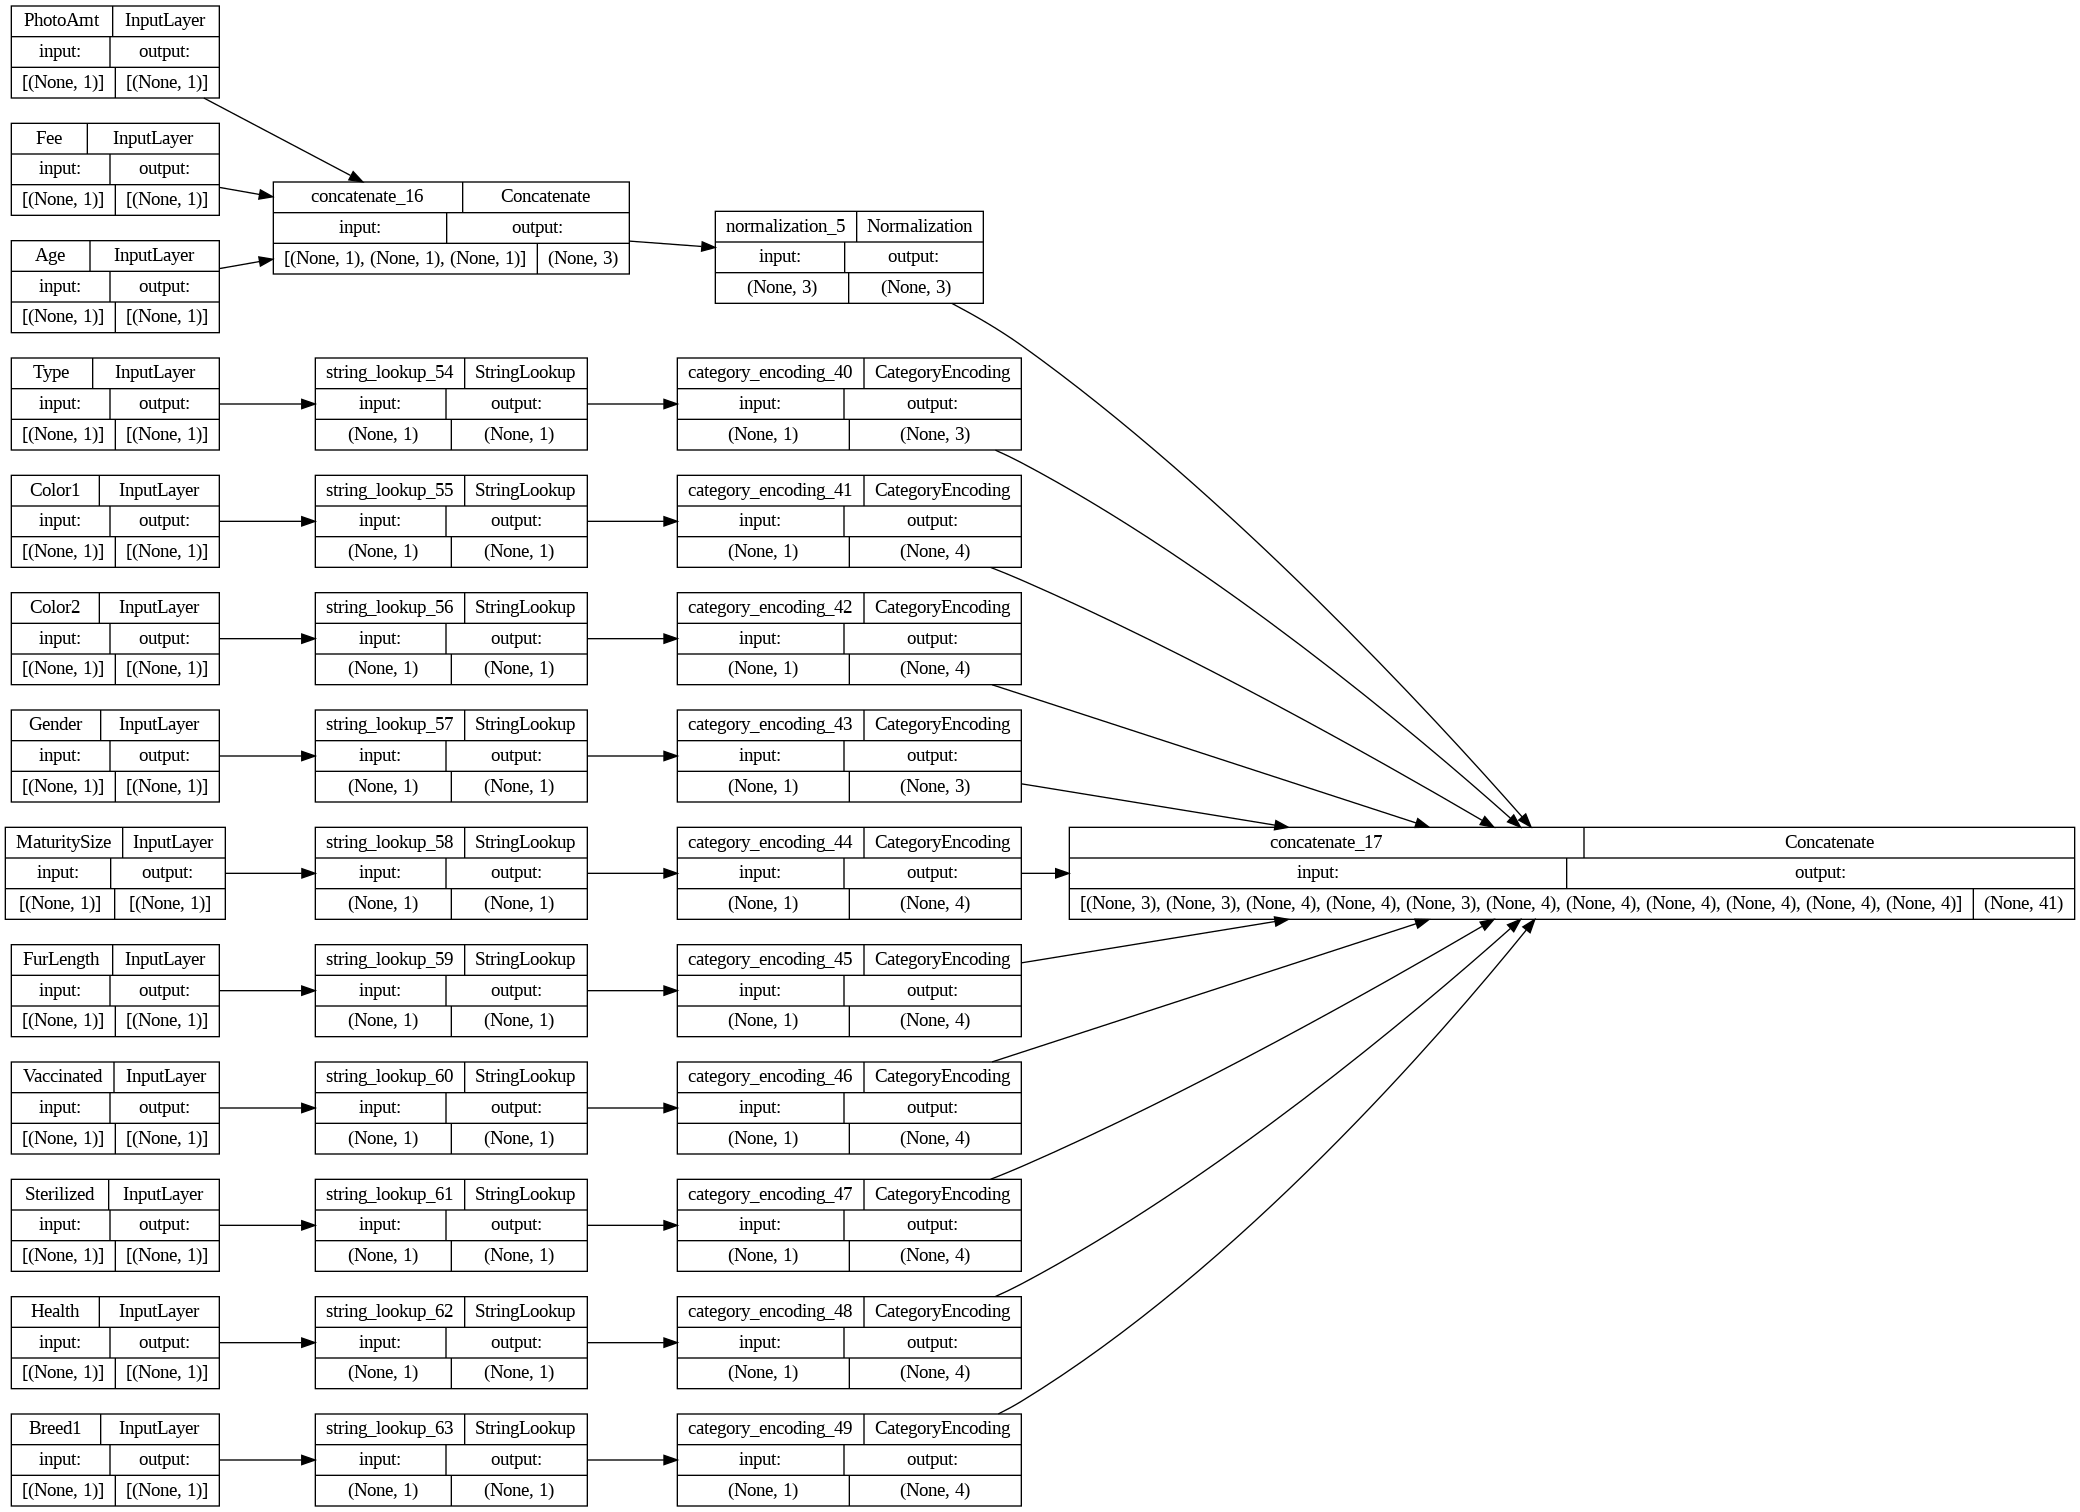

In [ ]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(preprocessing_model, show_shapes=True, rankdir="LR")

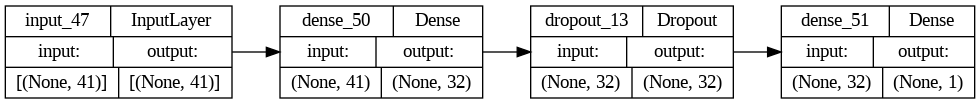

In [ ]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(training_model, show_shapes=True, rankdir="LR")

Next, train and test the model:

In [28]:
# Apply preprocessing asynchonously with tf.data.
preprocessed_train_ds = train_ds.map(
    lambda x, y: (preprocessing_model(x), y),
    num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
preprocessed_val_ds = val_ds.map(
    lambda x, y: (preprocessing_model(x), y),
    num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
preprocessed_test_ds = test_ds.map(
    lambda x, y: (preprocessing_model(x), y),
    num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

In [29]:
# Now the GPU can focus on the training part of the model!
training_model.compile(optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=["accuracy"])
training_model.fit(
    preprocessed_train_ds, validation_data=preprocessed_val_ds, epochs=10)

Epoch 1/10
37/37 [==============================] - 1s 13ms/step - loss: 0.6179 - accuracy: 0.6974 - val_loss: 0.5635 - val_accuracy: 0.7279
Epoch 2/10
37/37 [==============================] - 0s 1ms/step - loss: 0.5876 - accuracy: 0.7190 - val_loss: 0.5563 - val_accuracy: 0.7314
Epoch 3/10
37/37 [==============================] - 0s 1ms/step - loss: 0.5663 - accuracy: 0.7312 - val_loss: 0.5522 - val_accuracy: 0.7314
Epoch 4/10
37/37 [==============================] - 0s 1ms/step - loss: 0.5618 - accuracy: 0.7332 - val_loss: 0.5495 - val_accuracy: 0.7374
Epoch 5/10
37/37 [==============================] - 0s 1ms/step - loss: 0.5497 - accuracy: 0.7372 - val_loss: 0.5472 - val_accuracy: 0.7409
Epoch 6/10
37/37 [==============================] - 0s 1ms/step - loss: 0.5553 - accuracy: 0.7325 - val_loss: 0.5457 - val_accuracy: 0.7452
Epoch 7/10
37/37 [==============================] - 0s 1ms/step - loss: 0.5470 - accuracy: 0.7390 - val_loss: 0.5443 - val_accuracy: 0.7461
Epoch 8/10
37/37 [=

In [30]:
loss, accuracy = training_model.evaluate(preprocessed_test_ds)
print("Accuracy", accuracy)

1/1 [==============================] - 0s 241ms/step - loss: 0.5142 - accuracy: 0.7565
Accuracy 0.7564991116523743


## Perform inference

The model you have developed can now classify a row from a CSV file directly after you've included the preprocessing layers inside the model itself.

You can now [save and reload the Keras model](../keras/save_and_load.ipynb) with `Model.save` and `Model.load_model` before performing inference on new data:

In [34]:
inputs = preprocessing_model.input
outputs = training_model(preprocessing_model(inputs))
inference_model = tf.keras.Model(inputs, outputs)

In [35]:
inference_model.save('my_pet_classifier')
reloaded_model = tf.keras.models.load_model('my_pet_classifier')

In [44]:
[(x,y)] = test_ds.take(1)
actual_test_labels = y.numpy()

In [46]:
thres = 0.5
test_pred_probs = inference_model.predict(test_ds)
test_pred_labels = (test_pred_probs>thres)*1.0
print(classification_report(actual_test_labels, test_pred_labels))
print(confusion_matrix(actual_test_labels, test_pred_labels)/len(actual_test_labels))

1/1 [==============================] - 0s 22ms/step
              precision    recall  f1-score   support

           0       0.61      0.15      0.24       297
           1       0.77      0.97      0.86       857

    accuracy                           0.76      1154
   macro avg       0.69      0.56      0.55      1154
weighted avg       0.73      0.76      0.70      1154

[[0.03812825 0.21923744]
 [0.02426343 0.71837088]]


In [47]:
test = pd.read_csv(TEST_DATA_FILE, header=0)
test['test_pred_probs'] = test_pred_probs
test.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target,test_pred_probs
0,Cat,2,Domestic Medium Hair,Female,Gray,No Color,Small,Medium,No,No,Healthy,0,1,1,0.763150
1,Cat,5,Domestic Short Hair,Male,Yellow,No Color,Medium,Short,Yes,Yes,Healthy,100,30,1,0.913932
2,Dog,36,Rottweiler,Male,Black,Cream,Large,Short,Yes,Yes,Healthy,0,4,1,0.700239
3,Cat,12,Domestic Short Hair,Female,Black,White,Medium,Short,Yes,Yes,Healthy,0,2,0,0.510498
4,Dog,60,Beagle,Male,Black,Brown,Medium,Medium,No,No,Minor Injury,0,5,1,0.784358


## Calculating eval metrics for a subset of data

In [49]:
thres = 0.5
sample_test_data = test.loc[test['Health'] == 'Minor Injury']
sample_actual_test_labels = sample_test_data.target
sample_test_pred_probs = sample_test_data.test_pred_probs
sample_test_pred_labels = (sample_test_pred_probs>thres)*1.0
print(classification_report(sample_actual_test_labels, sample_test_pred_labels))
print(confusion_matrix(sample_actual_test_labels, sample_test_pred_labels)/len(sample_actual_test_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.65      1.00      0.78        20

    accuracy                           0.65        31
   macro avg       0.32      0.50      0.39        31
weighted avg       0.42      0.65      0.51        31

[[0.         0.35483871]
 [0.         0.64516129]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


To get a prediction for a new sample, you can simply call the Keras `Model.predict` method. There are just two things you need to do:

1.   Wrap scalars into a list so as to have a batch dimension (`Model`s only process batches of data, not single samples).
2.   Call `tf.convert_to_tensor` on each feature.

In [ ]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

1/1 [==============================] - 1s 501ms/step
This particular pet had a 83.7 percent probability of getting adopted.


Note: You will typically have better results with deep learning with larger and more complex datasets. When working with a small dataset, such as the simplified PetFinder.my one, you can use a <a href="https://developers.google.com/machine-learning/glossary#decision-tree" class="external">decision tree</a> or a <a href="https://developers.google.com/machine-learning/glossary#random-forest" class="external">random forest</a> as a strong baseline. The goal of this tutorial is to demonstrate the mechanics of working with structured data, so you have a starting point when working with your own datasets in the future.


## Next steps

To learn more about classifying structured data, try working with other datasets. To improve accuracy during training and testing your models, think carefully about which features to include in your model and how they should be represented.

Below are some suggestions for datasets:

- [TensorFlow Datasets: MovieLens](https://www.tensorflow.org/datasets/catalog/movie_lens): A set of movie ratings from a movie recommendation service.
- [TensorFlow Datasets: Wine Quality](https://www.tensorflow.org/datasets/catalog/wine_quality): Two datasets related to red and white variants of the Portuguese "Vinho Verde" wine. You can also find the Red Wine Quality dataset on <a href="https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009" class="external">Kaggle</a>.
- <a href="https://www.kaggle.com/Cornell-University/arxiv" class="external">Kaggle: arXiv Dataset</a>: A corpus of 1.7 million scholarly articles from arXiv, covering physics, computer science, math, statistics, electrical engineering, quantitative biology, and economics.
